In [1]:
import os
os.chdir('../')

In [81]:
import sys
import datetime
import logging
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

import torch
from torch import optim
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from lateral_connections.model_factory import load_model_by_key, get_config_by_key
from lateral_connections.loaders import *
from lateral_connections.loaders import get_loaders, load_mnistc

import wandb
import optuna

In [4]:
def small_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
    ])

In [5]:
def get_mnistc_loader(variant):
    dataset = load_mnistc(variant, transform=small_transform())
    return torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False, num_workers=1)

In [96]:
def check_mnist_c(model, run_config):
    wandb_run_name = run_config['wandb_run_name']

    mnist_c_variants = [
        'identity', 'pixelate', 'dotted_line', 'gaussian_blur', 'elastic_transform', 'jpeg_compression', 'speckle_noise',
        'glass_blur', 'spatter', 'translate', 'fog', 'shear', 'scale', 'zigzag', 'defocus_blur', 'gaussian_noise',
        'contrast', 'canny_edges', 'zoom_blur', 'line', 'pessimal_noise', 'rotate', 'brightness', 'shot_noise',
        'saturate', 'motion_blur', 'snow', 'inverse', 'impulse_noise', 'stripe', 'quantize', 'frost'
    ]
    data = []

    model.eval()

    for variant in tqdm(mnist_c_variants, desc='MNIST-C Variants', leave=False):
        loader = get_mnistc_loader(variant)
        c_acc, c_loss = model.test(loader)
        
        print(f"{wandb_run_name.ljust(45)}\t{variant.ljust(20)}\t{round(c_acc,4)}")
        data.append({
            'model': wandb_run_name,
            'mnist_c_variant': variant,
            'accuracy': c_acc
        })

    df = pd.DataFrame(data)
    df['model_type'] = run_config['model_type']
    #df.to_csv(wandb_run_name + '__results.csv', index=False)

In [179]:
def load_model(run_config):
    config = get_config_by_key('tiny_lateral_net')
    config['batch_size'] = 10
    config['lcl_alpha'] = 0.0012
    config['lcl_distance'] = 0
    config['lcl_eta'] = 0.05
    config['learning_rate'] = 3.6e-4
    config['num_multiplex'] = 5

    model = load_model_by_key('tiny_lateral_net', config=config)

    wandb.login(key='efd0a05b7bd26ed445bf073625a373b845fc9385')
    wandb.init(
        project='MT_LateralConnections',
        entity='lehl',
        group='eval',
        name='xxx',
        config=config,
        mode='disabled',
        reinit=True
    )

    model.load('models/tiny_cnn/' + run_config['wandb_run_name'] + '__best.pt')
    return model, config
    #check_mnist_c(model, run_config)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


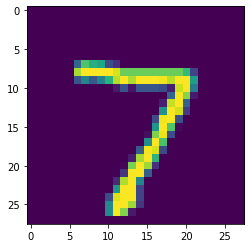

In [180]:
runs = [
    {'model_type': 'TinyLateralNet__FullyTrained', 'wandb_run_name': '2022-07-01_140041'},
    #         {'model_type': 'TinyLateralNet__FullyTrained', 'wandb_run_name': '2022-07-01_140924'},
    #         {'model_type': 'TinyLateralNet__FullyTrained', 'wandb_run_name': '2022-07-01_141201'},
    #         {'model_type': 'TinyLateralNet__FullyTrained', 'wandb_run_name': '2022-07-01_141404'},
    #         {'model_type': 'TinyLateralNet__FullyTrained', 'wandb_run_name': '2022-07-01_123010'},
    #         {'model_type': 'TinyLateralNet__FullyTrained', 'wandb_run_name': '2022-07-01_123034'},
    #         {'model_type': 'TinyLateralNet__FullyTrained', 'wandb_run_name': '2022-07-01_123026'},
    #         {'model_type': 'TinyLateralNet__FullyTrained', 'wandb_run_name': '2022-07-01_123018'},
]

for run_config in runs:
    network, config = load_model(run_config)

loader = get_mnistc_loader('identity')
plt.imshow(loader.dataset[0][0].permute(1,2,0))

In [188]:
class InverseTLN(nn.Module):
    def __init__(self, network, height=28, width=28):
        super(InverseTLN, self).__init__()
        self.height = height
        self.width = width
        self.network = network
        
        for p in self.network.parameters():
            p.requires_grad = False
        self.reset_weight()
        
    def reset_weight(self):
        self.weight = self.init_weight()
        
    def init_weight(self):
        w = torch.empty(config['batch_size'], 1, self.height, self.width)
        torch.nn.init.uniform_(w, 0, 1.0)
        
        param = torch.nn.Parameter(w)
        param.requires_grad = True
        return param
    
    def _transform(self):
        return transforms.Normalize(mean=(0.5), std=(0.5))
    
    def forward(self, x):
        image = torch.tanh(torch.relu(self.weight.to(self.network.device)))
        image = self._transform()(image)
        return self.network(image)
    
itln = InverseTLN(network)
itln

InverseTLN(
  (network): TinyLateralNet(
    (conv): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_act): Tanh()
    (maxpool): AdaptiveMaxPool2d(output_size=(14, 14))
    (fc1): Linear(in_features=1960, out_features=100, bias=True)
    (fc1_act): ReLU()
    (fc2): Linear(in_features=100, out_features=10, bias=True)
    (loss_fn): CrossEntropyLoss()
    (lcl): LaterallyConnectedLayer3(5, (10, 14, 14), d=0, disabled=False, update=False)
  )
)

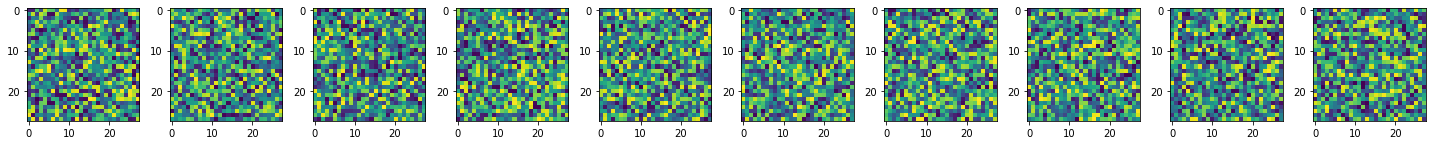

In [189]:
def plot_weight(weight):
    if weight.shape[0] == 1:
        fig, ax = plt.subplots(figsize=(4,4))
        ax.imshow(weight.permute(1,2,0).cpu().detach().numpy(), cmap='viridis')
        
    else:
        fig, axs = plt.subplots(1, weight.shape[0], figsize=(20,2))

        for i in range(weight.shape[0]):
            axs[i].imshow(weight[i, ...].permute(1,2,0).cpu().detach().numpy(), cmap='viridis')
    
    plt.tight_layout()
    plt.show()
    
plot_weight(itln.weight)

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(9.0121)


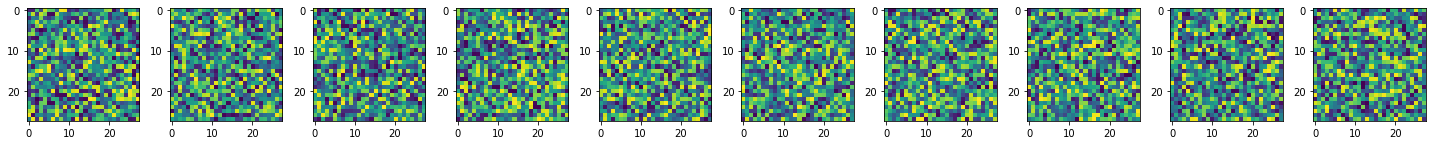

tensor(0.0538)


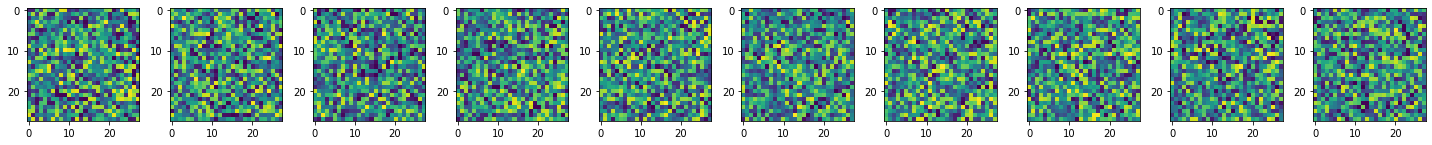

tensor(0.0207)


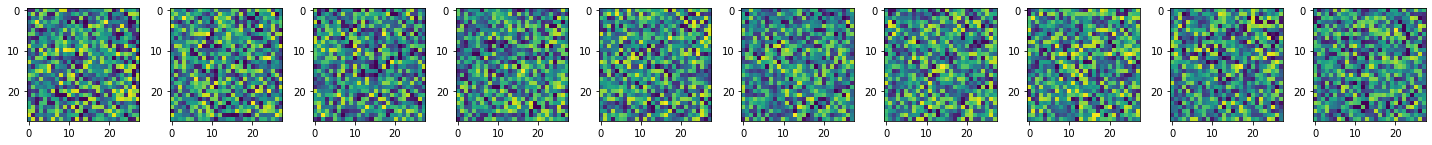

tensor(0.0107)


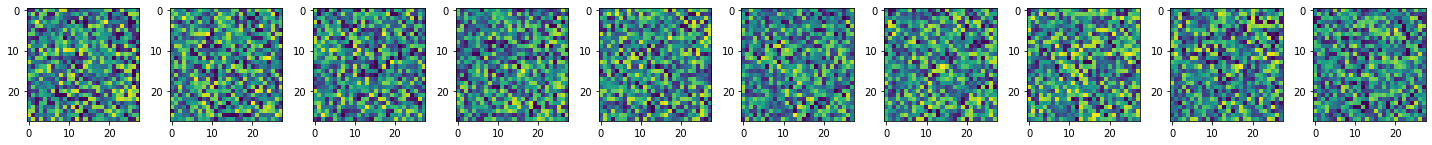

tensor(0.0065)


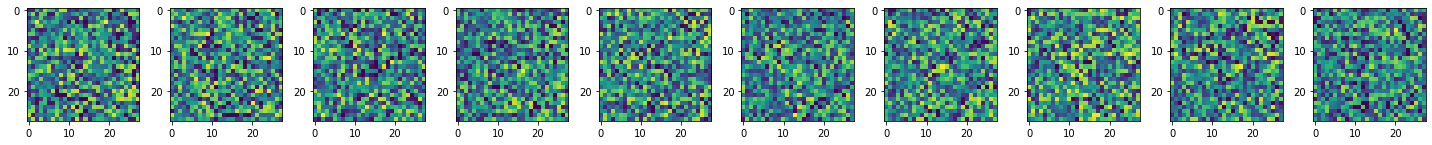

In [ ]:
num_it = 10000

label = torch.ones([config['batch_size']]).to(torch.long) * 8
label = label.to(itln.network.device)

opt = optim.Adam(itln.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for i in tqdm(range(num_it)):
    prev_weight = torch.clone(itln.weight)
    
    opt.zero_grad()
    
    output = itln(None)
    #print(output.shape)
    loss = loss_fn(output, label)
    
    loss.backward()
    opt.step()
    
    if i % 200 == 0:
        print(itln.weight.grad.abs().sum())
        plot_weight(itln.weight)
        #pass
    
    
    
    